In [61]:
import numpy as np
import os
from astropy.io import fits
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import astropy.units as u
import ipywidgets as widgets
from ipywidgets import interact, IntSlider
from IPython.display import display, Image
from specutils import Spectrum1D, SpectralRegion
from spectral_cube import SpectralCube
from specutils.analysis import moment
from specutils.manipulation import spectral_slab
from astropy.modeling import models, fitting
from spectral_cube import SpectralCube
from scipy.ndimage import gaussian_filter, gaussian_laplace, find_objects
from scipy.optimize import curve_fit
from scipy.stats import kurtosis

work_dir = os.getcwd()


In [62]:
def compute_and_plot_fourier(data, title_prefix, slice_index):
    # Assicurati che l'indice della slice sia valido
    if slice_index < 0 or slice_index >= data.shape[0]:
        raise ValueError(f"Indice della slice {slice_index} non valido. Deve essere tra 0 e {data.shape[0] - 1}.")

    # Calcola la trasformata di Fourier solo per la slice selezionata
    slice_data = data[slice_index]
    fourier_transform = np.fft.fftn(slice_data)
    magnitude_transform = np.abs(fourier_transform)
    phase_transform = np.angle(fourier_transform)

    plt.figure(figsize=(12, 6))

    # Magnitudine
    plt.subplot(1, 2, 1)
    plt.imshow(np.log1p(np.fft.fftshift(magnitude_transform)), cmap='gray', origin='lower')
    plt.title(f'{title_prefix} - Magnitudine Slice {slice_index}')
    plt.colorbar()

    # Fase
    plt.subplot(1, 2, 2)
    plt.imshow(np.fft.fftshift(phase_transform), cmap='hsv', origin='lower')
    plt.title(f'{title_prefix} - Fase Slice {slice_index}')
    plt.colorbar()

    plt.tight_layout()
    plt.show()


In [63]:
# # Load the data
# filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec.fits"
# HDUL = fits.open(filename)
# data = HDUL[0].data  

# # Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
# integrated_flux = np.sum(data, axis=0)
# y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
# print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# # Step 2: Identify the slice that contains the maximum flux at the source coordinates
# # Extract the flux values at (x_center, y_center) across all slices
# source_spectrum = data[:, y_center, x_center]

# # Find the slice index with the maximum flux at the source coordinates
# max_slice_index = np.argmax(source_spectrum)
# print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# # Extract the 2D data from this slice
# slice_data = data[max_slice_index]

# # Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# # Create radial profile centered at (x_center, y_center)
# y, x = np.indices(slice_data.shape)
# r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
# r = r.astype(int)

# # Calculate the radial profile
# tbin = np.bincount(r.ravel(), slice_data.ravel())
# nr = np.bincount(r.ravel())
# radialprofile = tbin / nr

# # Apply smoothing to the radial profile to reduce noise
# radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# # Define the 90% of maximum flux threshold
# flux_threshold = 0.9 * np.max(radialprofile_smooth)

# # Find the radius where the radial profile drops to 90% of the maximum flux
# source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
# print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# # Estimate sigma as half of the radius (this is an approximation)
# sigma_fit = source_radius / 2.0
# print(f"Estimated sigma: {sigma_fit}")

# # Step 4: Calculate the background radius
# background_radius = int(3 * sigma_fit)
# print(f"Background radius: {background_radius}")

# # Step 5: Create masks for source and background regions in the selected slice
# source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
# background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
# background_mask &= ~source_mask

# # Mean of the source region
# mean_source = np.mean(slice_data[source_mask])
# print(f"Mean flux in the source region: {mean_source}")

# # Standard deviation of the background region
# std_background = np.std(slice_data[background_mask])
# print(f"Standard deviation in the background region: {std_background}")

# # Optional: Plot SNR in the source region
# snr_source = mean_source / std_background
# print(f"SNR in the source region: {snr_source}")

# # Step 6: Pixel flux distribution of the selected slice
# plt.figure(figsize=(10, 6))
# plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
# plt.xlabel('Pixel Flux')
# plt.ylabel('Number of Pixels')
# plt.title('Pixel Flux Distribution of the Selected Slice')
# plt.grid(True)
# plt.show()
# kurt = kurtosis(slice_data.ravel(),fisher=True)
# print(f'Kurtosis is : {kurt}')
# # Close the FITS file
# HDUL.close()

# # Visualize the regions if needed
# plt.figure(figsize=(6, 6))
# plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
# plt.title('Source (red) and Background (green) Regions')
# plt.colorbar(label='Region Mask')
# plt.show()

In [64]:
# # Load the data
# filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\adjusted_simulated.fits"
# # Load the data
# HDUL = fits.open(filename)
# data = HDUL[0].data  

# # Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
# integrated_flux = np.sum(data, axis=0)
# y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
# print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# # Step 2: Identify the slice that contains the maximum flux at the source coordinates
# # Extract the flux values at (x_center, y_center) across all slices
# source_spectrum = data[:, y_center, x_center]

# # Find the slice index with the maximum flux at the source coordinates
# max_slice_index = np.argmax(source_spectrum)
# print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# # Extract the 2D data from this slice
# slice_data = data[max_slice_index]

# # Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# # Create radial profile centered at (x_center, y_center)
# y, x = np.indices(slice_data.shape)
# r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
# r = r.astype(int)

# # Calculate the radial profile
# tbin = np.bincount(r.ravel(), slice_data.ravel())
# nr = np.bincount(r.ravel())
# radialprofile = tbin / nr

# # Apply smoothing to the radial profile to reduce noise
# radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# # Define the 90% of maximum flux threshold
# flux_threshold = 0.9 * np.max(radialprofile_smooth)

# # Find the radius where the radial profile drops to 90% of the maximum flux
# source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
# print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# # Estimate sigma as half of the radius (this is an approximation)
# sigma_fit = source_radius / 2.0
# print(f"Estimated sigma: {sigma_fit}")

# # Step 4: Calculate the background radius
# background_radius = int(3 * sigma_fit)
# print(f"Background radius: {background_radius}")

# # Step 5: Create masks for source and background regions in the selected slice
# source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
# background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
# background_mask &= ~source_mask

# # Mean of the source region
# mean_source = np.mean(slice_data[source_mask])
# print(f"Mean flux in the source region: {mean_source}")

# # Standard deviation of the background region
# std_background = np.std(slice_data[background_mask])
# print(f"Standard deviation in the background region: {std_background}")

# # Optional: Plot SNR in the source region
# snr_source = mean_source / std_background
# print(f"SNR in the source region: {snr_source}")

# # Step 6: Pixel flux distribution of the selected slice
# plt.figure(figsize=(10, 6))
# plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
# plt.xlabel('Pixel Flux')
# plt.ylabel('Number of Pixels')
# plt.title('Pixel Flux Distribution of the Selected Slice')
# plt.grid(True)
# plt.show()
# kurt = kurtosis(slice_data.ravel(),fisher=True)
# print(f'Kurtosis is : {kurt}')
# # Close the FITS file
# HDUL.close()

# # Visualize the regions if needed
# plt.figure(figsize=(6, 6))
# plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
# plt.title('Source (red) and Background (green) Regions')
# plt.colorbar(label='Region Mask')
# plt.show()

Source coordinates (from integrated flux): (x_center, y_center) = (75, 75)
Slice with maximum flux at the source coordinates: 484
Source radius corresponding to 90% of maximum flux: 3
Estimated sigma: 1.5
Background radius: 4
Overall SNR of the cube: 6.562193393707275
Kurtosis is : -0.0026476941496169637


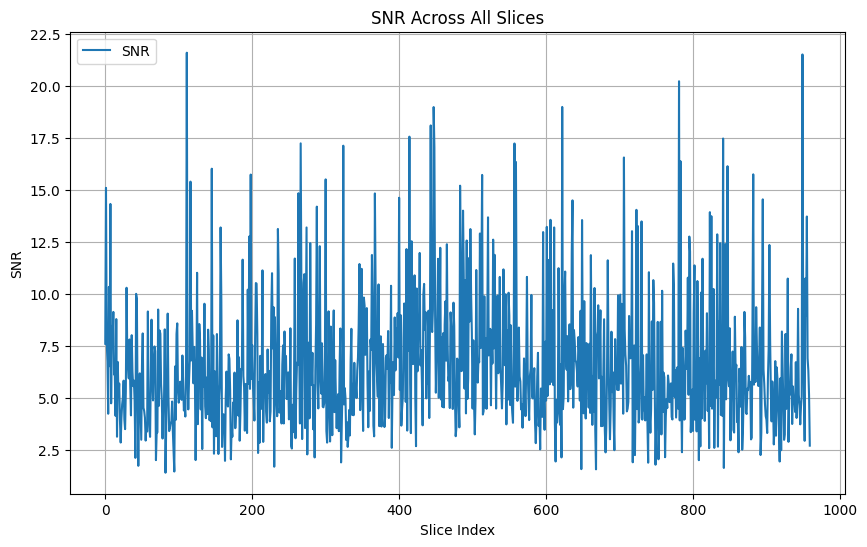

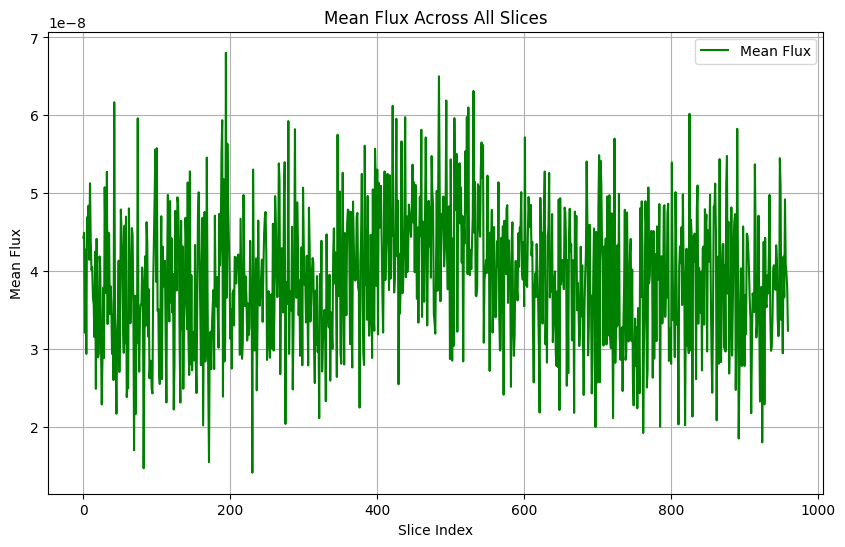

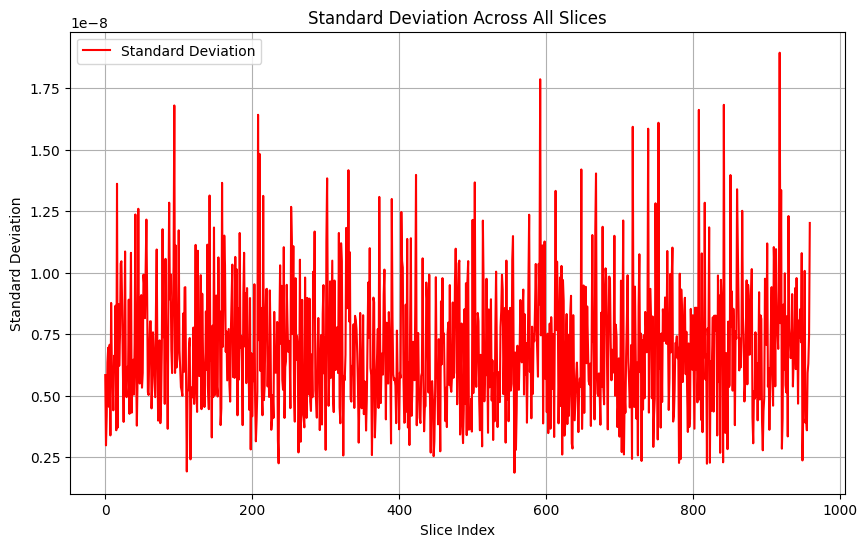

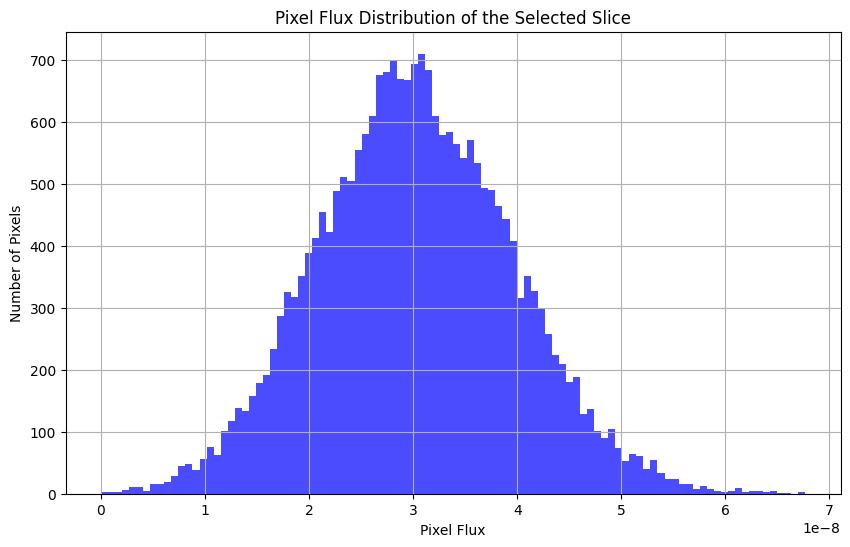

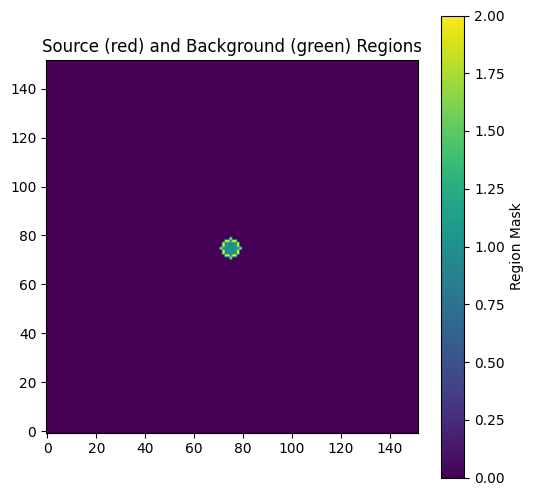

In [65]:

# Aprire il file FITS
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\adjusted_simulated.fits"

# Load the data
HDUL = fits.open(filename)
data = HDUL[0].data  

# Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
integrated_flux = np.sum(data, axis=0)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# Step 2: Identify the slice that contains the maximum flux at the source coordinates
# Extract the flux values at (x_center, y_center) across all slices
source_spectrum = data[:, y_center, x_center]

# Find the slice index with the maximum flux at the source coordinates
max_slice_index_mock = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index_mock}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index_mock]

# Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.90 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 4: Calculate the background radius
background_radius = int(3 * sigma_fit)
print(f"Background radius: {background_radius}")

# Step 5: Create masks for source and background regions based on the source slice
source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
background_mask &= ~source_mask

# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()



Source coordinates (from integrated flux): (x_center, y_center) = (56, 91)
Slice with maximum flux at the source coordinates: 0
Source radius corresponding to 90% of maximum flux: 2
Estimated sigma: 1.0
Background radius: 3
Overall SNR of the cube: 0.3312220871448517
Kurtosis is : -0.04244839175553494


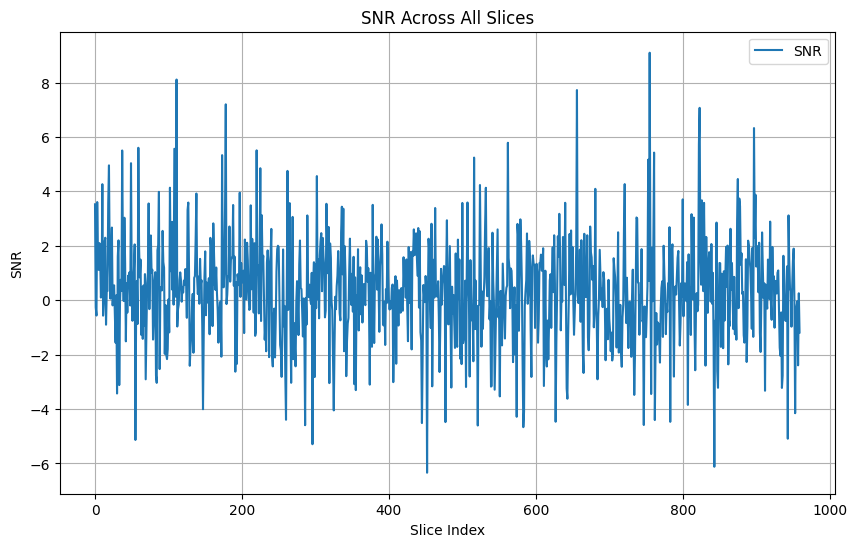

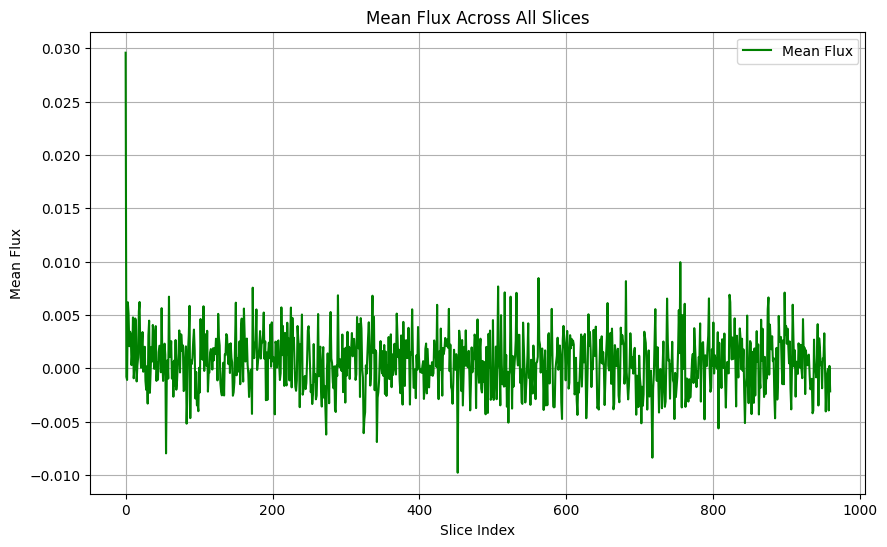

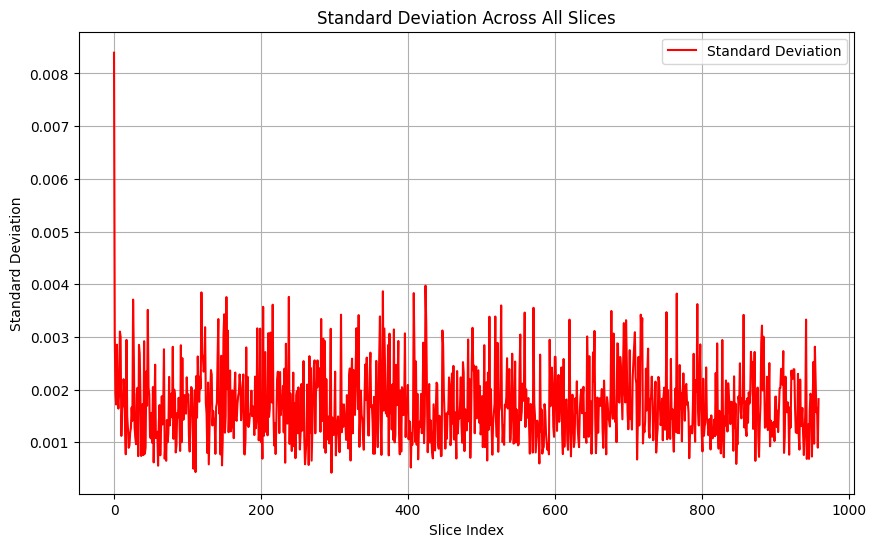

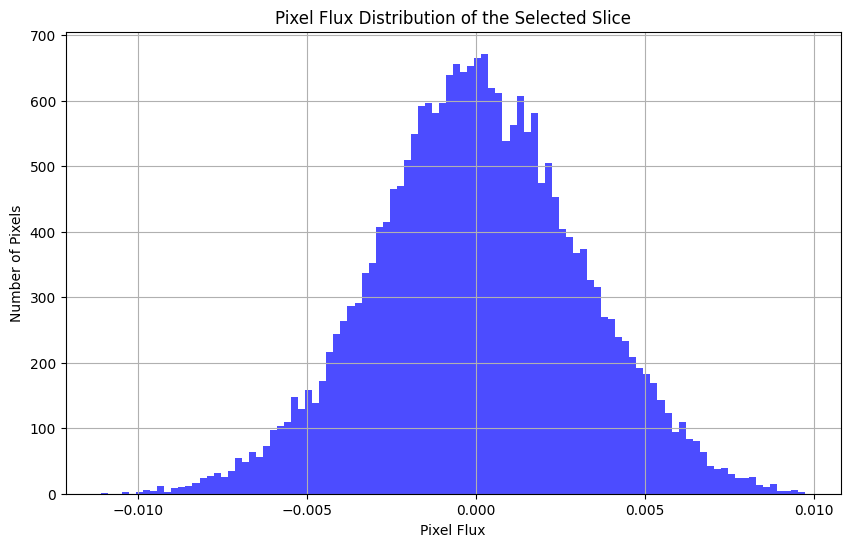

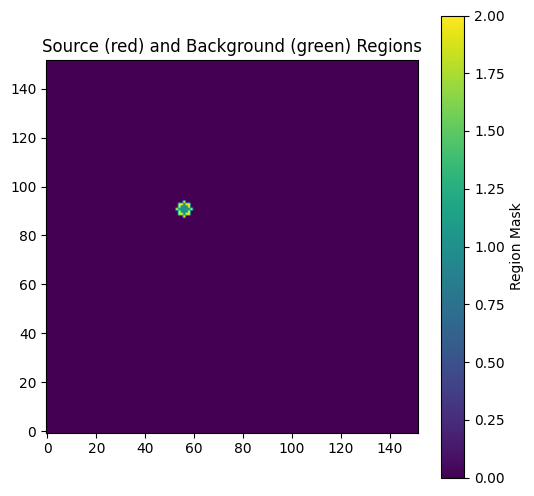

In [66]:

# Aprire il file FITS
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec.fits"

HDUL = fits.open(filename)
data = HDUL[0].data  

# Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
integrated_flux = np.sum(data, axis=0)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# Step 2: Identify the slice that contains the maximum flux at the source coordinates
# Extract the flux values at (x_center, y_center) across all slices
source_spectrum = data[:, y_center, x_center]

# Find the slice index with the maximum flux at the source coordinates
max_slice_index_mock = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index_mock}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index_mock]

# Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.90 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 4: Calculate the background radius
background_radius = int(3 * sigma_fit)
print(f"Background radius: {background_radius}")

# Step 5: Create masks for source and background regions based on the source slice
source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
background_mask &= ~source_mask

# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()



Source coordinates (from integrated flux): (x_center, y_center) = (80, 80)
Slice with maximum flux at the source coordinates: 35
Source radius corresponding to 90% of maximum flux: 2
Estimated sigma: 1.0
Background radius: 3
Overall SNR of the cube: 0.7419965863227844
Kurtosis is : -0.1332354710245558


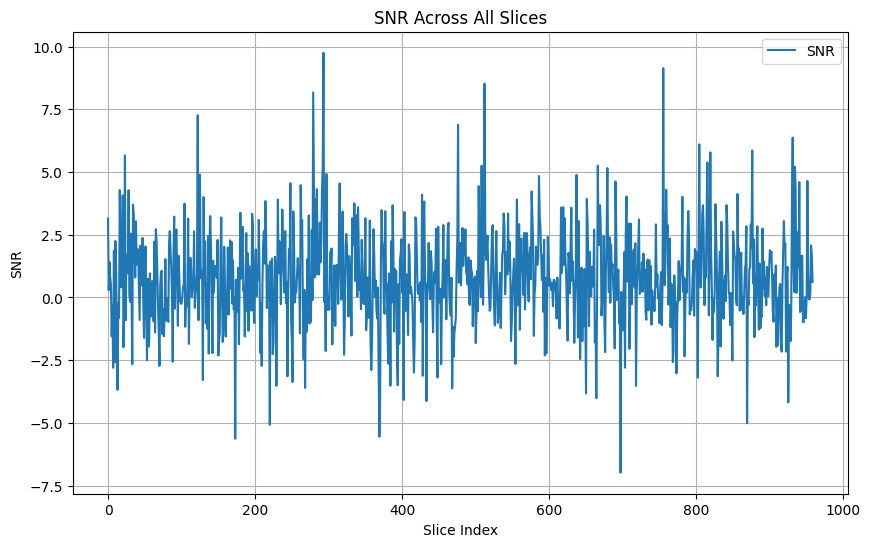

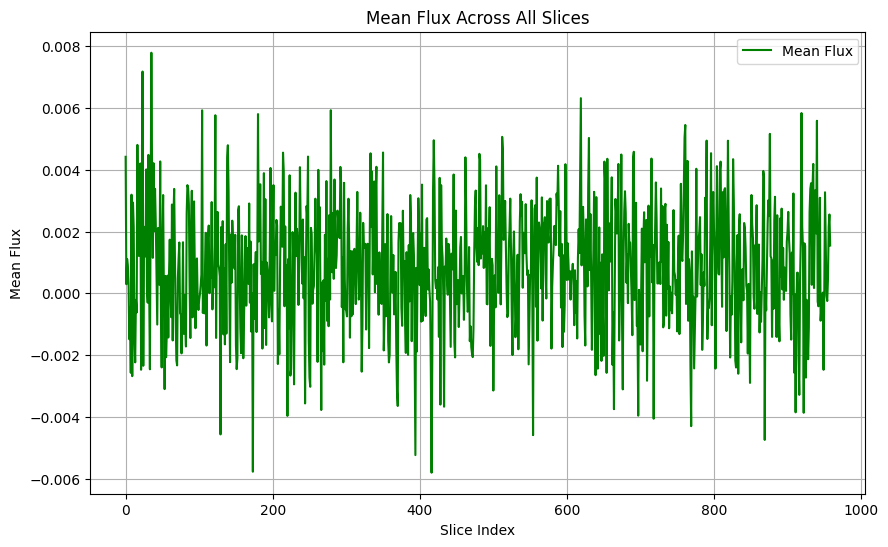

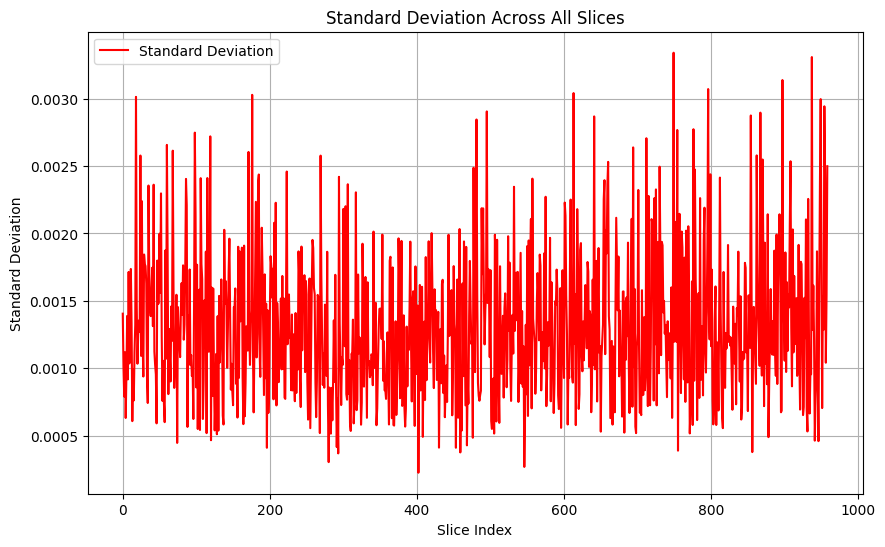

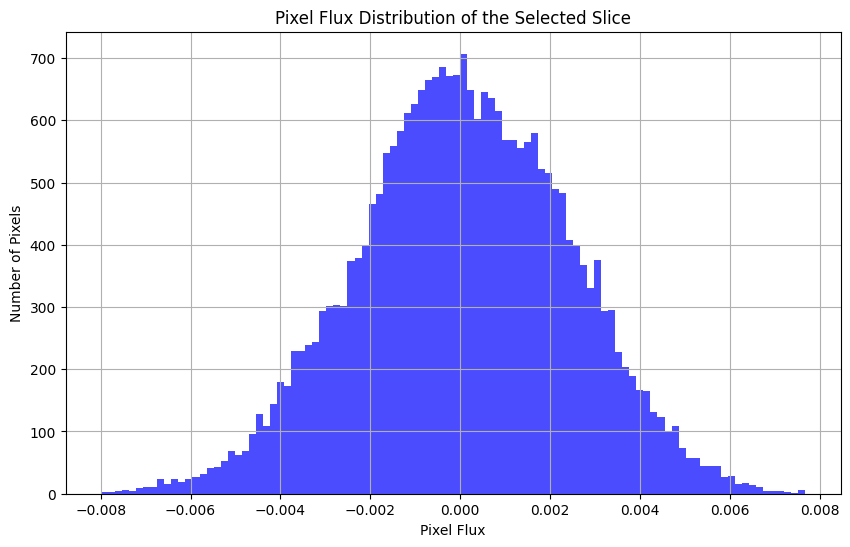

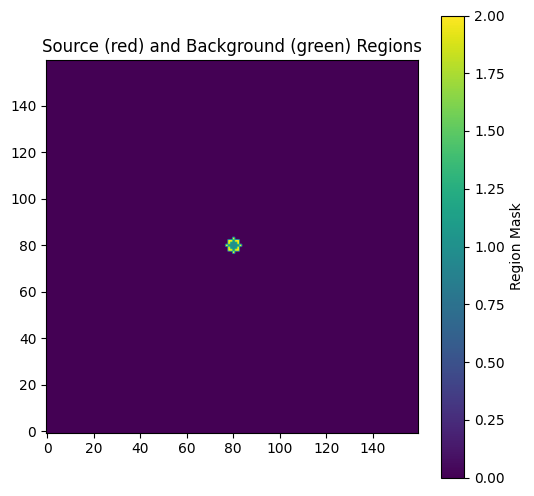

In [67]:

# Aprire il file FITS
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_J1306+03_a_06_TE_muid___A001_X2fb_X40c.fits"
HDUL = fits.open(filename)
data = HDUL[0].data  

# Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
integrated_flux = np.sum(data, axis=0)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# Step 2: Identify the slice that contains the maximum flux at the source coordinates
# Extract the flux values at (x_center, y_center) across all slices
source_spectrum = data[:, y_center, x_center]

# Find the slice index with the maximum flux at the source coordinates
max_slice_index_mock = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index_mock}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index_mock]

# Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.90 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 4: Calculate the background radius
background_radius = int(3 * sigma_fit)
print(f"Background radius: {background_radius}")

# Step 5: Create masks for source and background regions based on the source slice
source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
background_mask &= ~source_mask

# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()



In [68]:
# filename_real = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec.fits"
# filename_mock = r"C:\Users\lsann\Desktop\test\cropped_cubes\adjusted_simulated.fits"

# HDUL_real = fits.open(filename_real)
# data_real = HDUL_real[0].data

# HDUL_mock = fits.open(filename_mock)
# data_mock = HDUL_mock[0].data


# compute_and_plot_fourier(data_real, title_prefix='Dati Reali', slice_index=3)


# compute_and_plot_fourier(data_mock, title_prefix='Dati Mock', slice_index=max_slice_index_mock)

# # Chiudere i file FITS
# HDUL_real.close()
# HDUL_mock.close()

(480, 50, 50)
Source coordinates (from integrated flux): (x_center, y_center) = (25, 24)
Slice with maximum flux at the source coordinates: 148
Source radius corresponding to 90% of maximum flux: 3
Estimated sigma: 1.5
Background radius: 4
Overall SNR of the cube: 0.32432207465171814
Kurtosis is : -0.3337468963900392


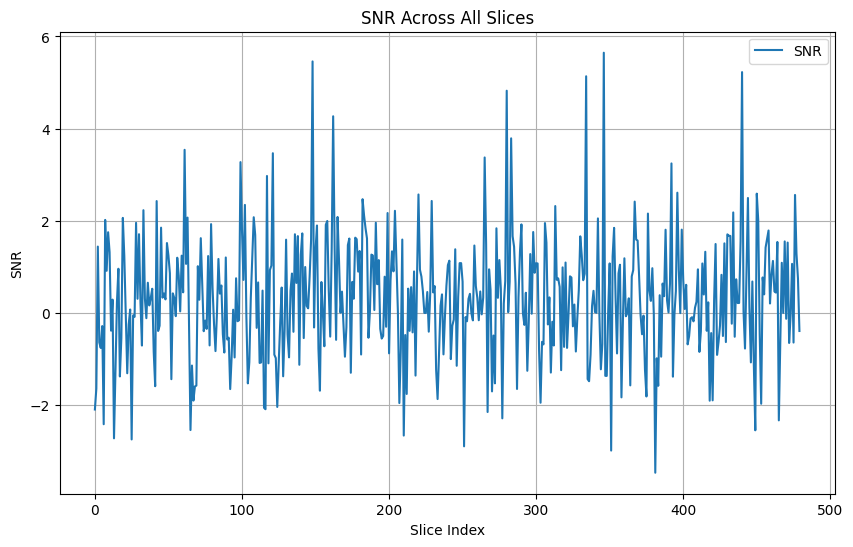

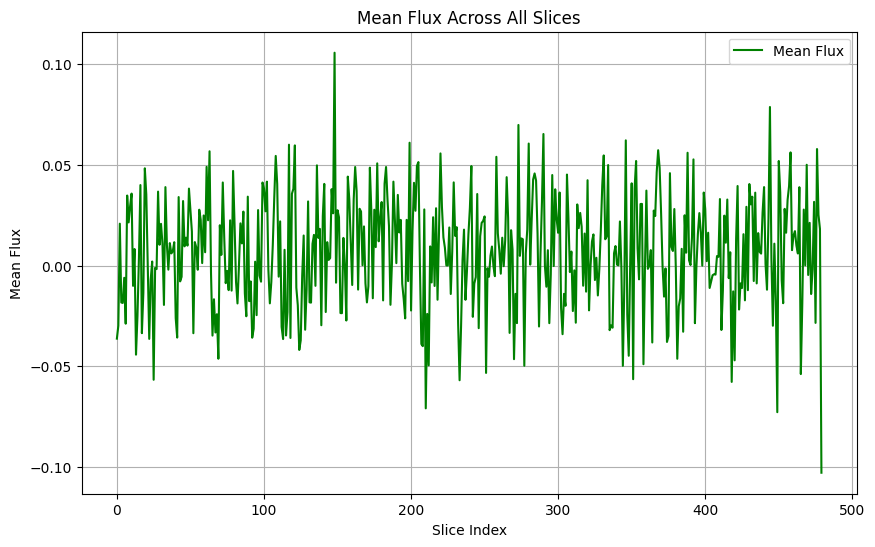

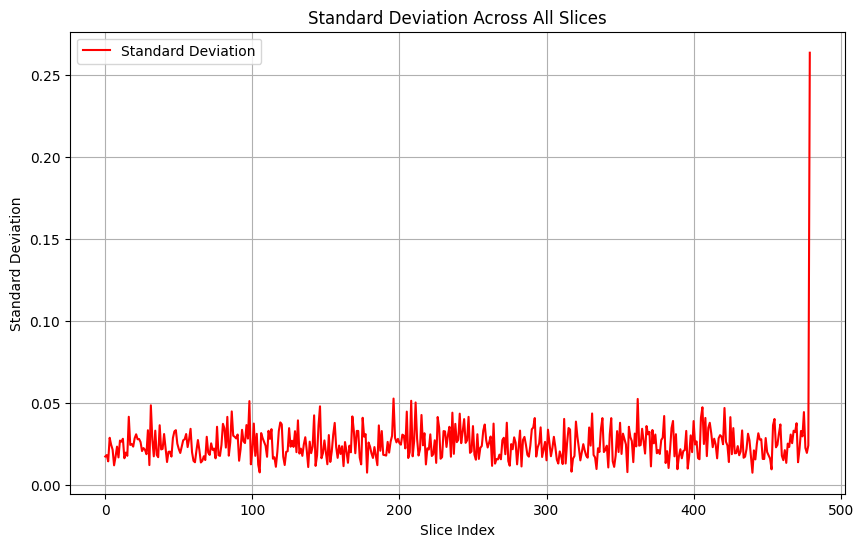

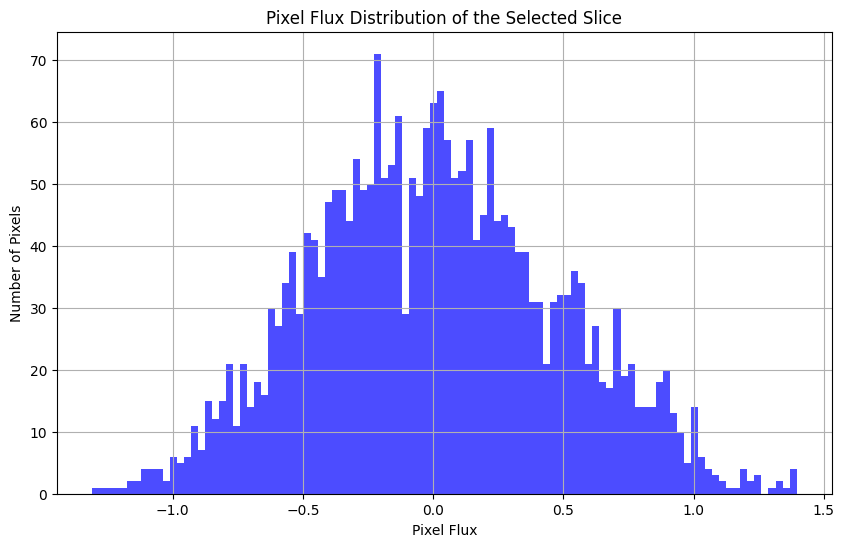

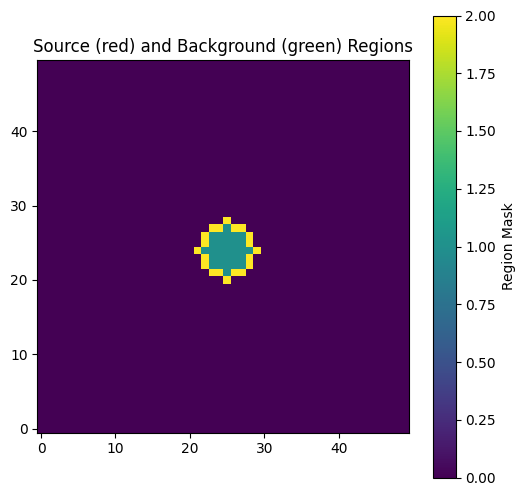

In [69]:

# Aprire il file FITS
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_PJ231-20_a_08_7M_muid___A001_X15aa_X1f7.fits"

# Load the data
HDUL = fits.open(filename)
data = HDUL[0].data 
data = np.squeeze(data) 
print(data.shape)
# Step 1: Find the source coordinates (x_center, y_center) in the integrated flux map
integrated_flux = np.sum(data, axis=0)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (from integrated flux): (x_center, y_center) = ({x_center}, {y_center})")

# Step 2: Identify the slice that contains the maximum flux at the source coordinates
# Extract the flux values at (x_center, y_center) across all slices
source_spectrum = data[:, y_center, x_center]

# Find the slice index with the maximum flux at the source coordinates
max_slice_index_real = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index_real}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index_real]

# Step 3: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.66 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 4: Calculate the background radius
background_radius = int(3 * sigma_fit)
print(f"Background radius: {background_radius}")

# Step 5: Create masks for source and background regions based on the source slice
source_mask = (x - x_center)**2 + (y - y_center)**2 <= source_radius**2
background_mask = (x - x_center)**2 + (y - y_center)**2 <= background_radius**2
background_mask &= ~source_mask

# Step 6: Compute mean, standard deviation, and SNR for all slices
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")
kurt = kurtosis(slice_data.ravel(),fisher=True)
print(f'Kurtosis is : {kurt}')

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()


Source coordinates (after filtering): (x_center, y_center) = (154, 153)
Slice with maximum flux at the source coordinates: 418
Source radius corresponding to 90% of maximum flux: 2
Estimated sigma: 1.0
Overall SNR of the cube: 1.0156875848770142


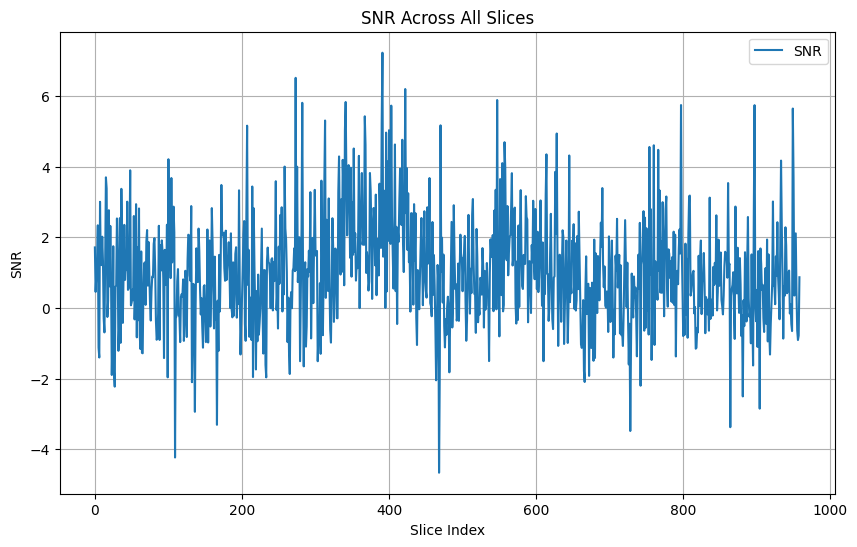

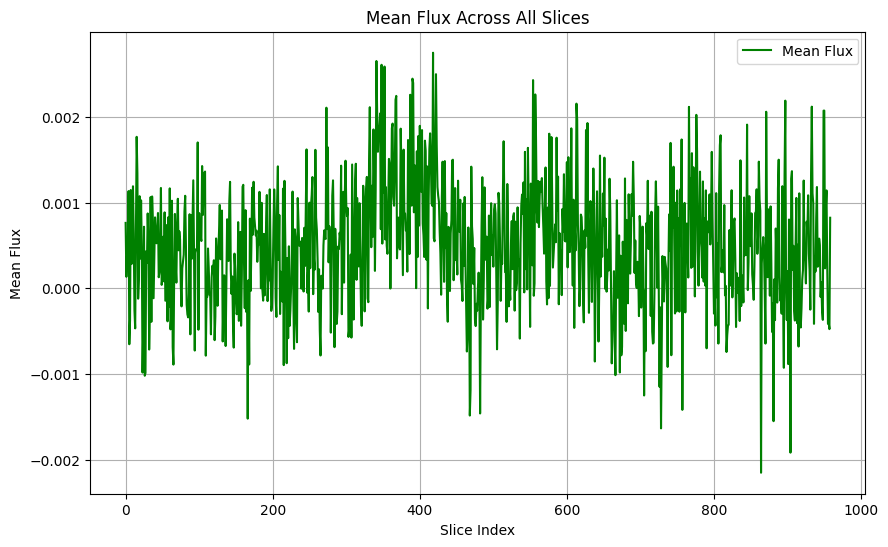

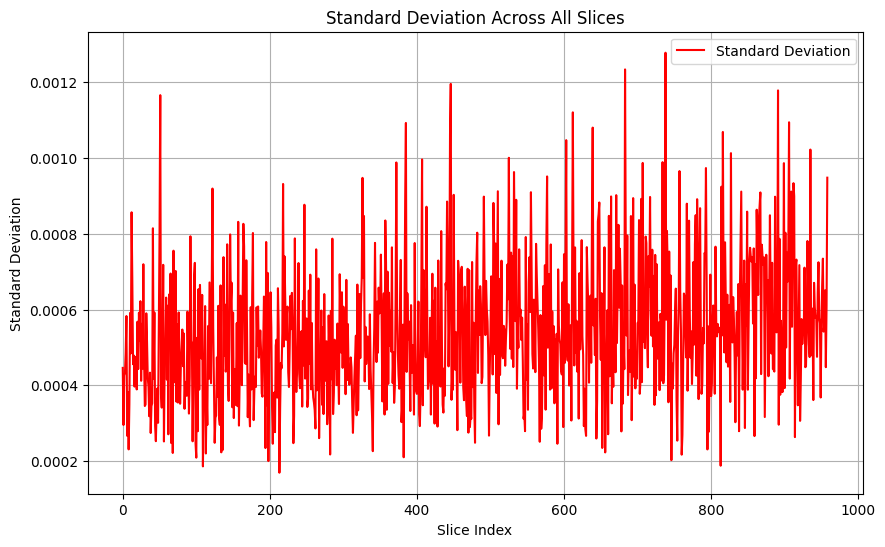

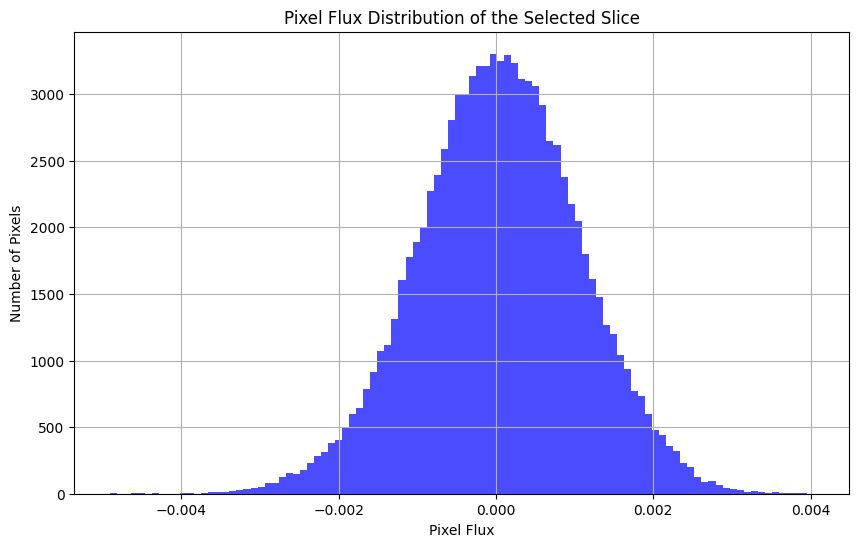

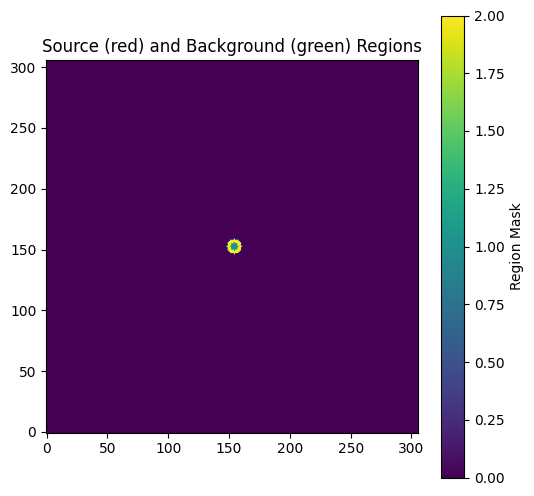

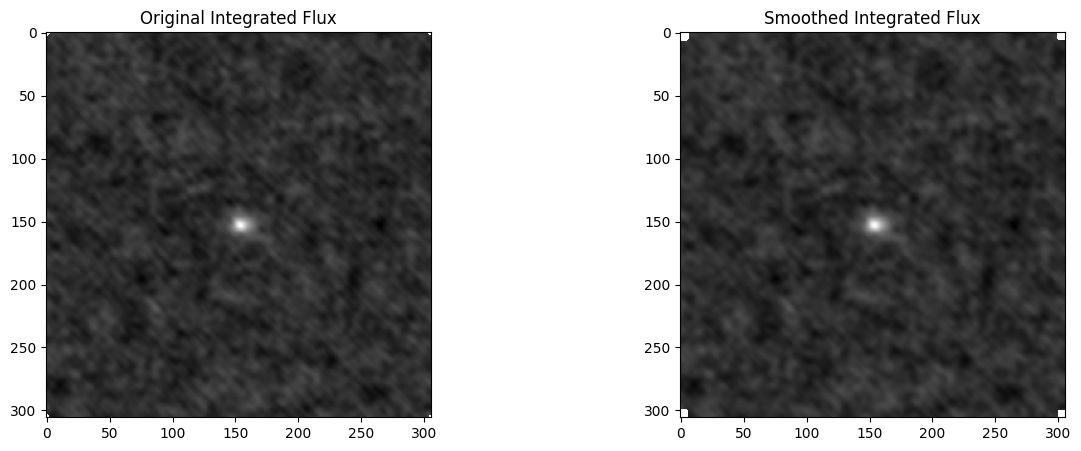

In [70]:
# Aprire il file FITS
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_J1319+09_a_03_TM1_muid___A001_X1465_X380c.fits"

HDUL = fits.open(filename, memmap=True)
data = HDUL[0].data  

# Step 1: Apply Gaussian smoothing to enhance faint sources
smoothed_data = gaussian_filter(data, sigma=1)

# Integrated flux map
integrated_flux = np.sum(smoothed_data, axis=0)

# Step 2: Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (after filtering): (x_center, y_center) = ({x_center}, {y_center})")

# Step 3: Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Step 4: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.9 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:  # Prevent zero radius issue
    source_radius = np.argmax(radialprofile_smooth > 0)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 5: Create masks for the source region and the background annulus
# Source mask: 3 sigma around the source center
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2

# Background annulus mask: between 3 sigma and 6 sigma
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Step 6: Compute mean, standard deviation, and SNR for all slices using the defined masks
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()

# Optional: Visualize the original and smoothed data for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.sum(data, axis=0), cmap='gray')
plt.title('Original Integrated Flux')

plt.subplot(1, 2, 2)
plt.imshow(np.sum(smoothed_data, axis=0), cmap='gray')
plt.title('Smoothed Integrated Flux')

plt.show()

Source coordinates (after filtering): (x_center, y_center) = (75, 75)
Slice with maximum flux at the source coordinates: 484
Source radius corresponding to 90% of maximum flux: 3
Estimated sigma: 1.5
Overall SNR of the cube: 4.742393493652344


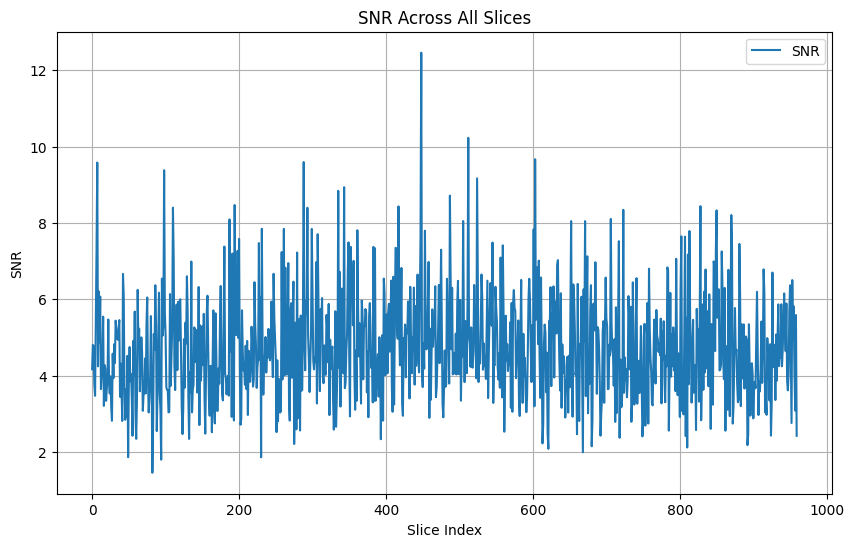

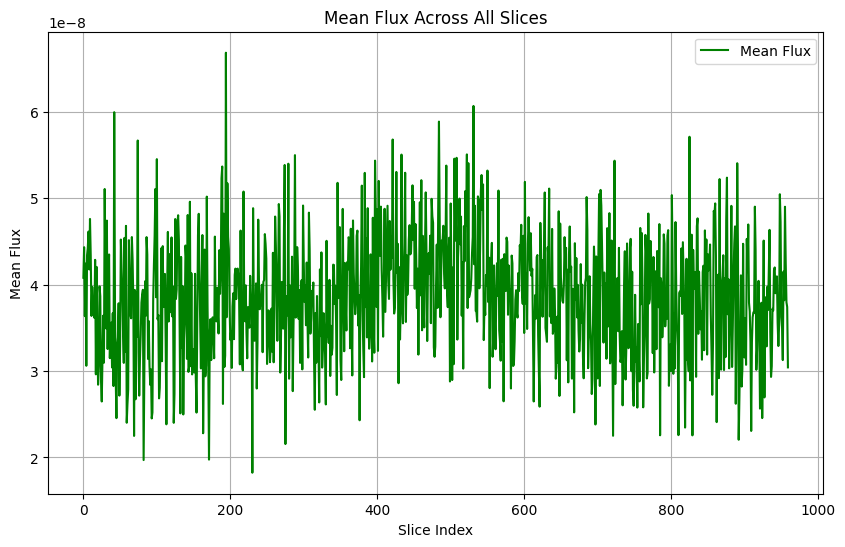

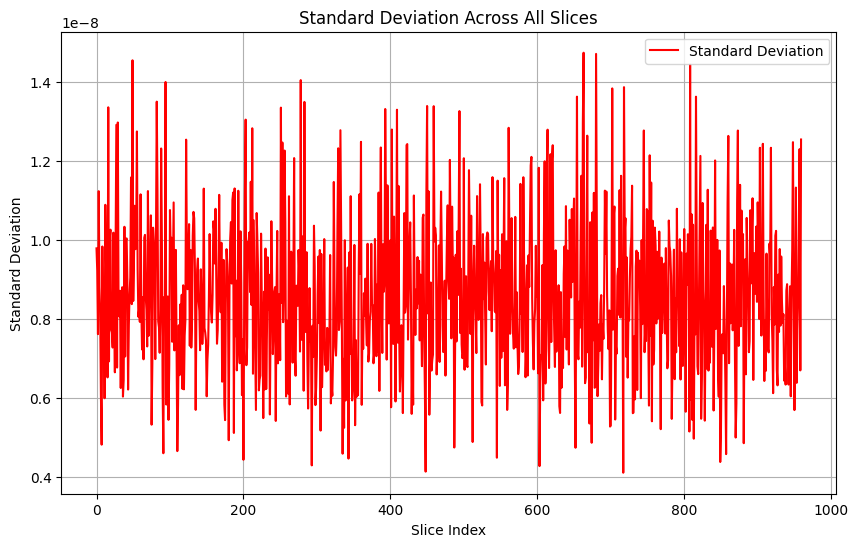

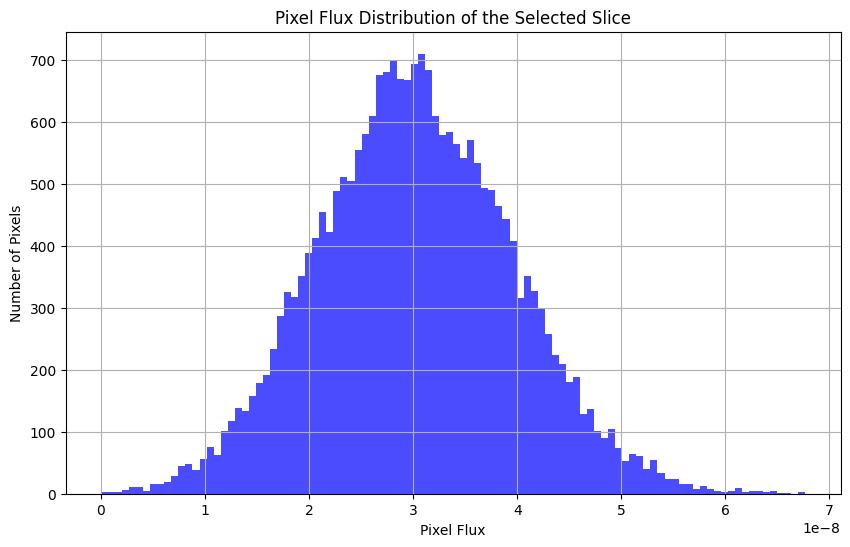

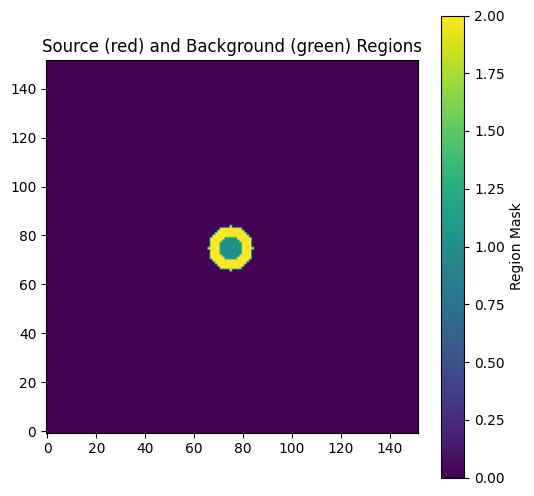

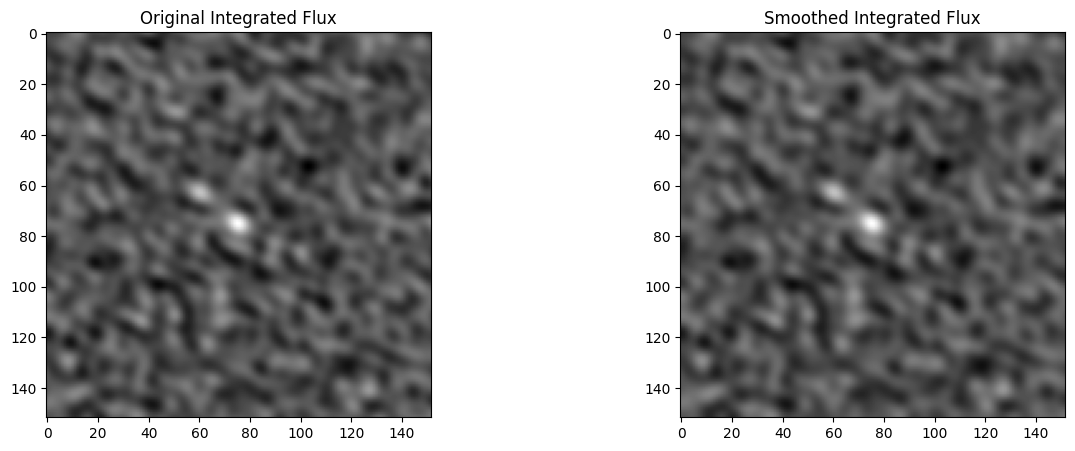

In [71]:
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\adjusted_simulated.fits"
HDUL = fits.open(filename, memmap=True)
data = HDUL[0].data  

# Step 1: Apply Gaussian smoothing to enhance faint sources
smoothed_data = gaussian_filter(data, sigma=1)

# Integrated flux map
integrated_flux = np.sum(smoothed_data, axis=0)

# Step 2: Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (after filtering): (x_center, y_center) = ({x_center}, {y_center})")

# Step 3: Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Step 4: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.9 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:  # Prevent zero radius issue
    source_radius = np.argmax(radialprofile_smooth > 0)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 5: Create masks for the source region and the background annulus
# Source mask: 3 sigma around the source center
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2

# Background annulus mask: between 3 sigma and 6 sigma
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Step 6: Compute mean, standard deviation, and SNR for all slices using the defined masks
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()

# Optional: Visualize the original and smoothed data for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.sum(data, axis=0), cmap='gray')
plt.title('Original Integrated Flux')

plt.subplot(1, 2, 2)
plt.imshow(np.sum(smoothed_data, axis=0), cmap='gray')
plt.title('Smoothed Integrated Flux')

plt.show()

Source coordinates (after filtering): (x_center, y_center) = (56, 91)
Slice with maximum flux at the source coordinates: 0
Source radius corresponding to 90% of maximum flux: 2
Estimated sigma: 1.0
Overall SNR of the cube: 0.20597101747989655


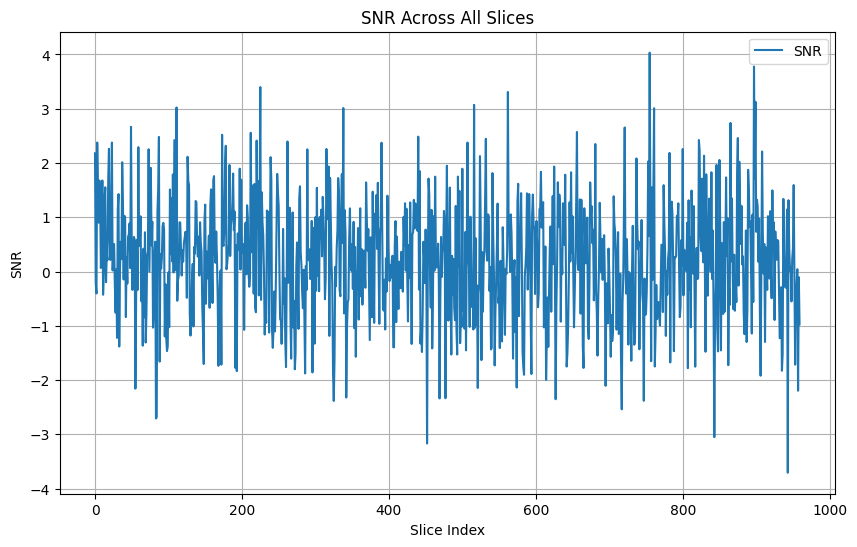

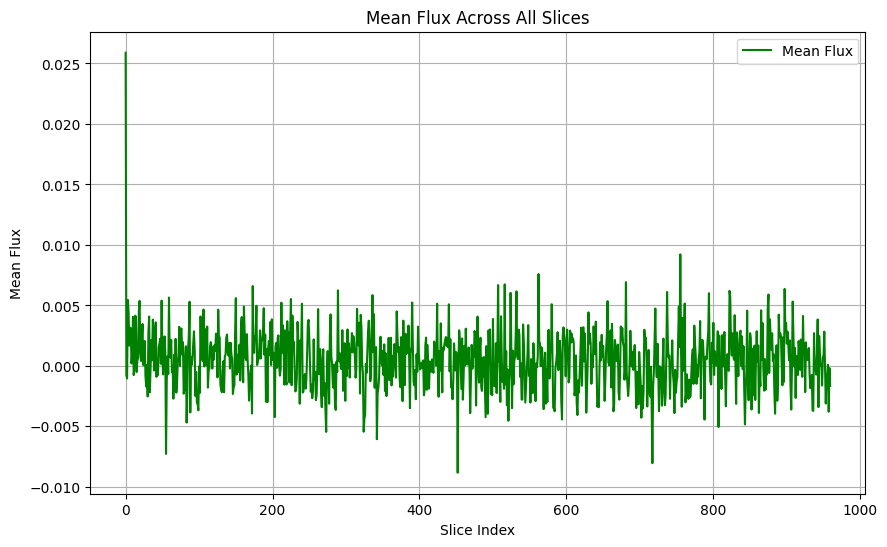

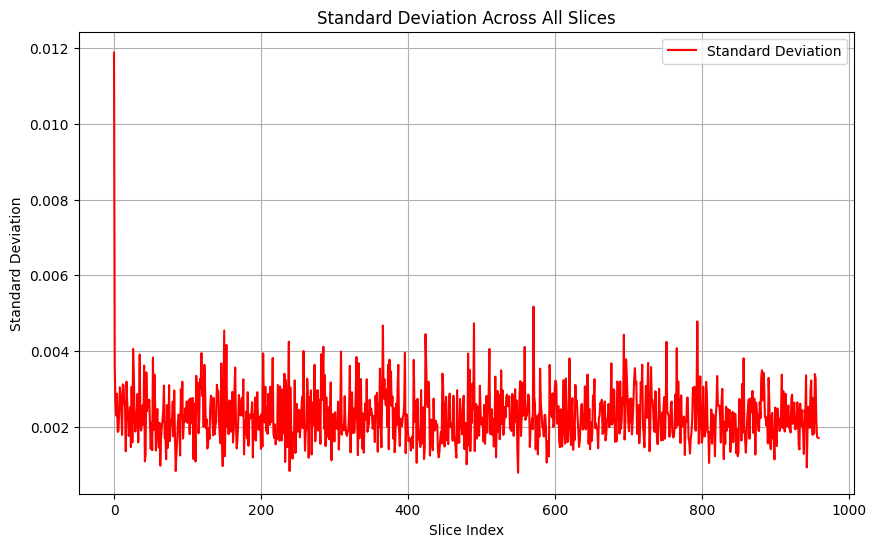

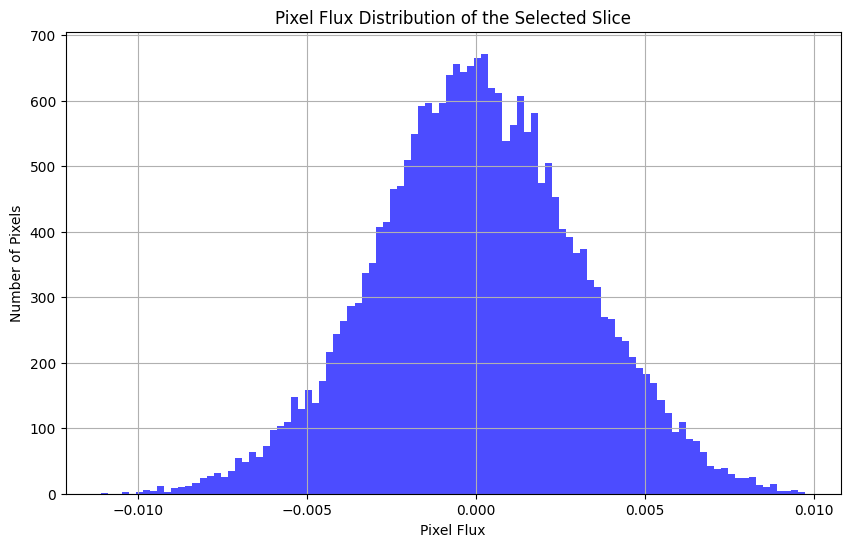

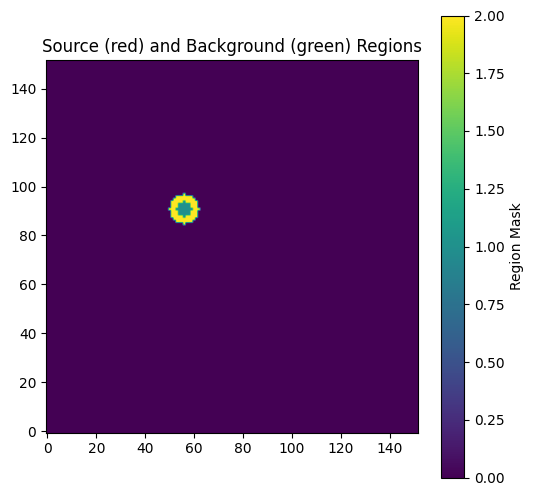

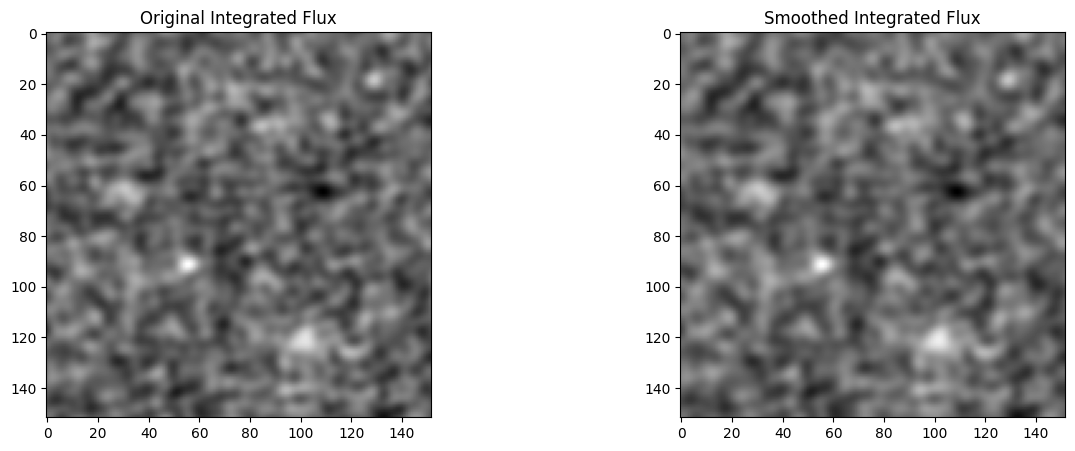

In [72]:
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_J0842+12_a_06_TE_muid___A001_X2fb_X3ec.fits"
HDUL = fits.open(filename, memmap=True)
data = HDUL[0].data  

# Step 1: Apply Gaussian smoothing to enhance faint sources
smoothed_data = gaussian_filter(data, sigma=1)

# Integrated flux map
integrated_flux = np.sum(smoothed_data, axis=0)

# Step 2: Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (after filtering): (x_center, y_center) = ({x_center}, {y_center})")

# Step 3: Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Step 4: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.9 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:  # Prevent zero radius issue
    source_radius = np.argmax(radialprofile_smooth > 0)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 5: Create masks for the source region and the background annulus
# Source mask: 3 sigma around the source center
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2

# Background annulus mask: between 3 sigma and 6 sigma
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Step 6: Compute mean, standard deviation, and SNR for all slices using the defined masks
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()

# Optional: Visualize the original and smoothed data for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.sum(data, axis=0), cmap='gray')
plt.title('Original Integrated Flux')

plt.subplot(1, 2, 2)
plt.imshow(np.sum(smoothed_data, axis=0), cmap='gray')
plt.title('Smoothed Integrated Flux')

plt.show()

Source coordinates (after filtering): (x_center, y_center) = (80, 80)
Slice with maximum flux at the source coordinates: 35
Source radius corresponding to 90% of maximum flux: 2
Estimated sigma: 1.0
Overall SNR of the cube: 0.4549901485443115


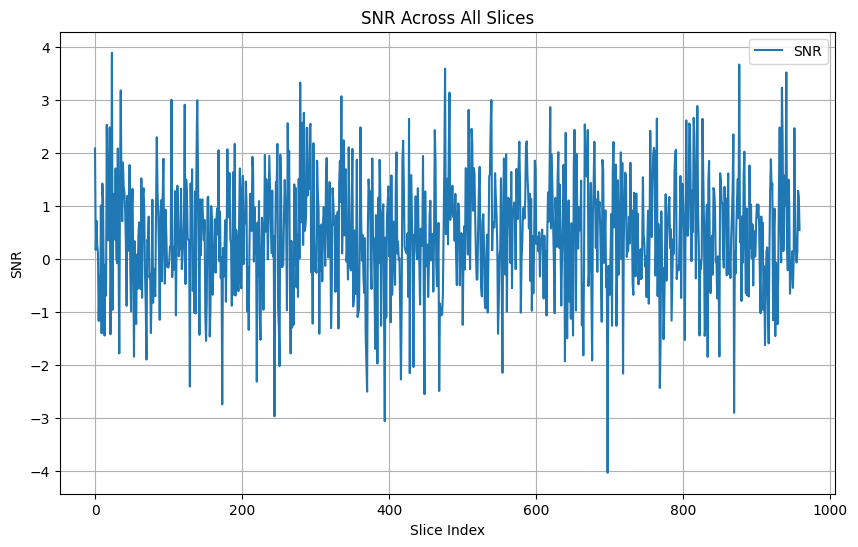

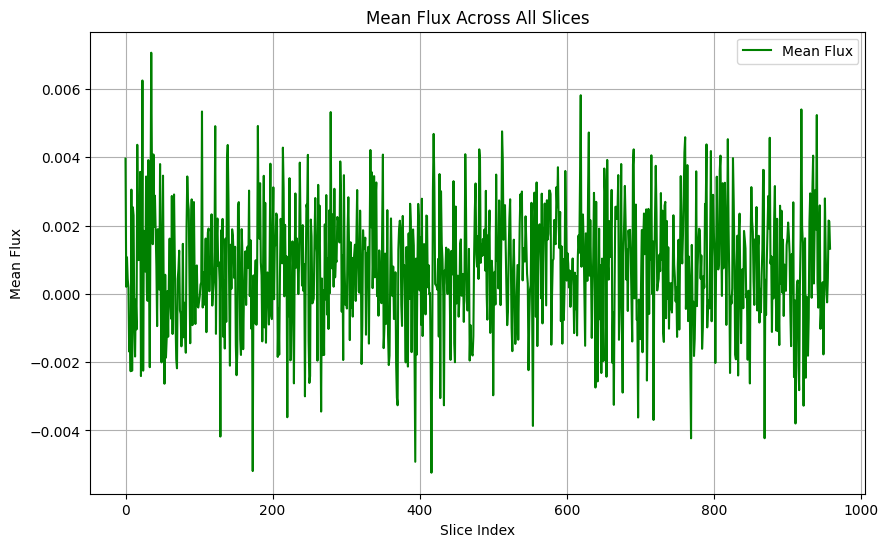

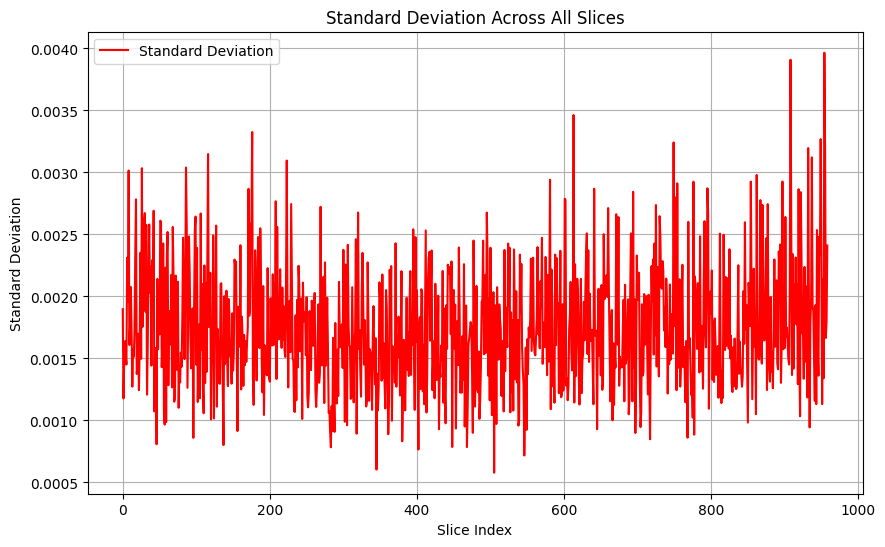

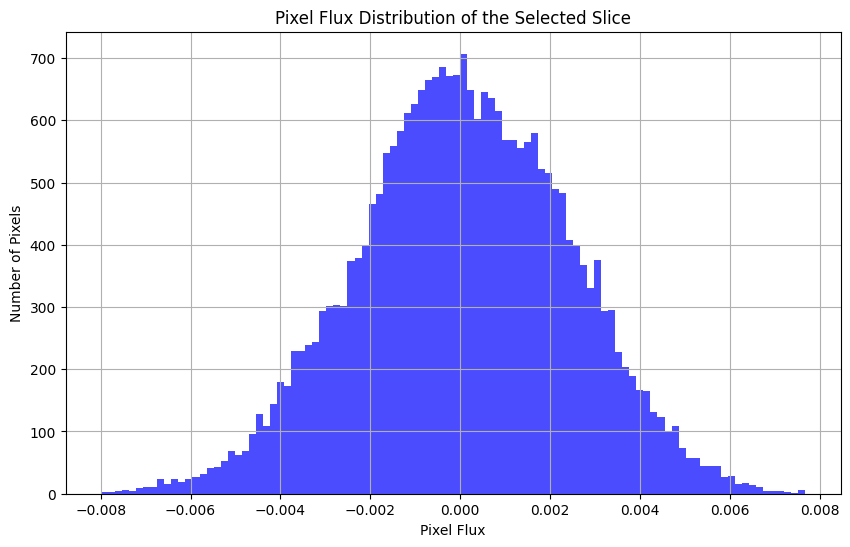

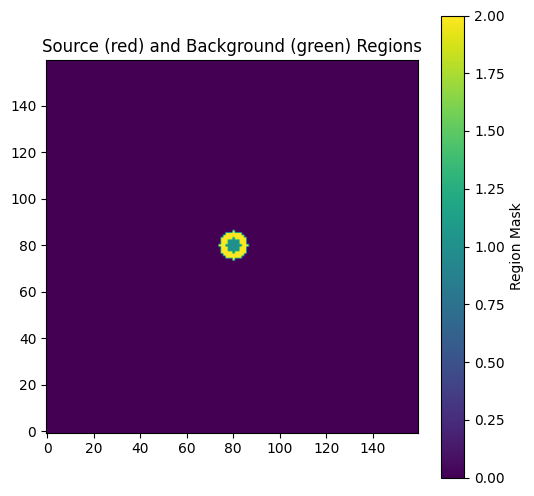

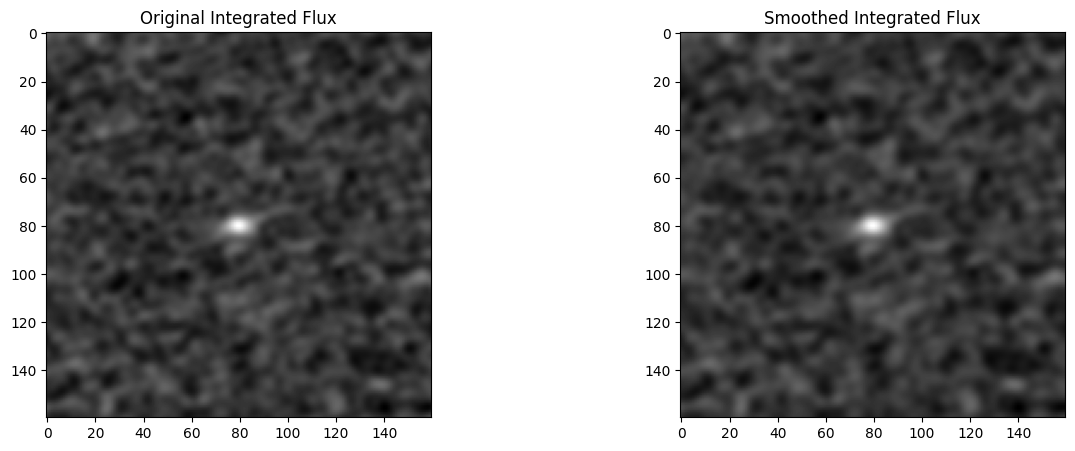

In [73]:
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_J1306+03_a_06_TE_muid___A001_X2fb_X40c.fits"
HDUL = fits.open(filename, memmap=True)
data = HDUL[0].data  

# Step 1: Apply Gaussian smoothing to enhance faint sources
smoothed_data = gaussian_filter(data, sigma=1)

# Integrated flux map
integrated_flux = np.sum(smoothed_data, axis=0)

# Step 2: Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (after filtering): (x_center, y_center) = ({x_center}, {y_center})")

# Step 3: Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Step 4: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.9 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:  # Prevent zero radius issue
    source_radius = np.argmax(radialprofile_smooth > 0)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 5: Create masks for the source region and the background annulus
# Source mask: 3 sigma around the source center
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2

# Background annulus mask: between 3 sigma and 6 sigma
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Step 6: Compute mean, standard deviation, and SNR for all slices using the defined masks
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()

# Optional: Visualize the original and smoothed data for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.sum(data, axis=0), cmap='gray')
plt.title('Original Integrated Flux')

plt.subplot(1, 2, 2)
plt.imshow(np.sum(smoothed_data, axis=0), cmap='gray')
plt.title('Smoothed Integrated Flux')

plt.show()

Source coordinates (after filtering): (x_center, y_center) = (25, 24)
Slice with maximum flux at the source coordinates: 148
Source radius corresponding to 90% of maximum flux: 2
Estimated sigma: 1.0
Overall SNR of the cube: 0.24992288649082184


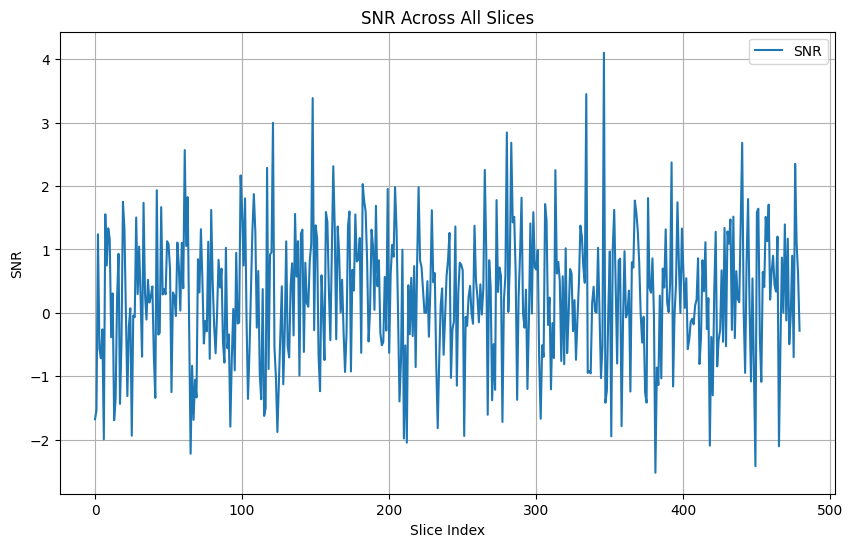

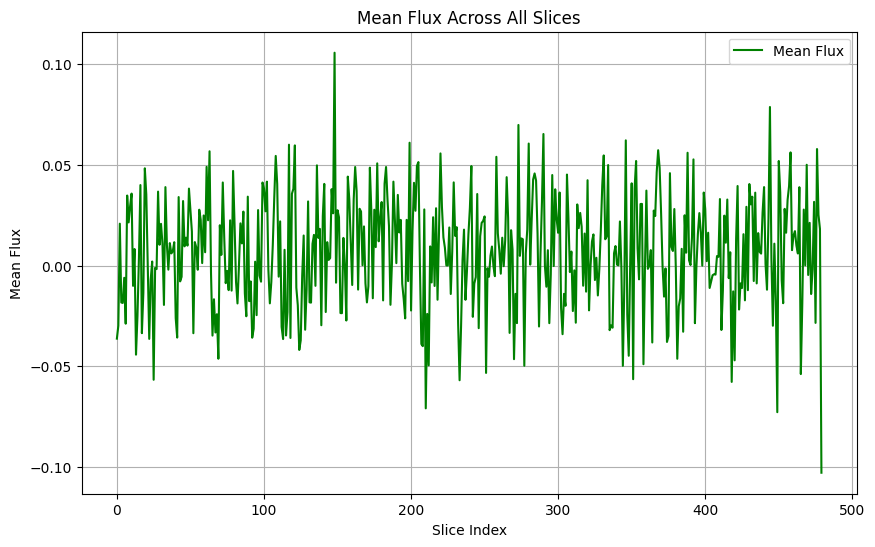

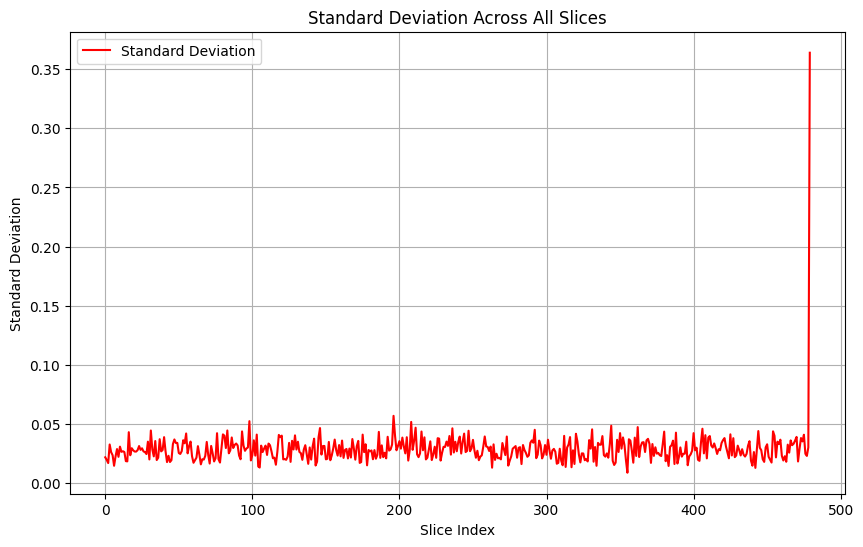

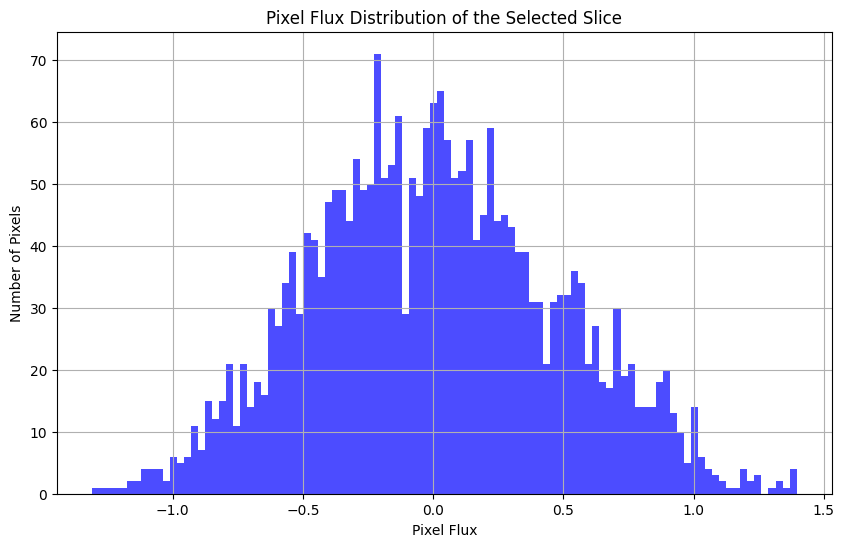

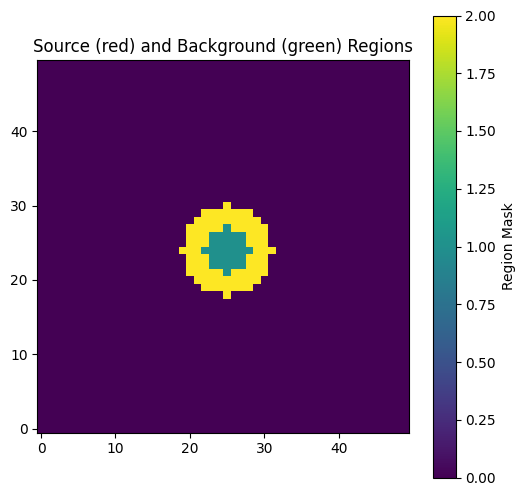

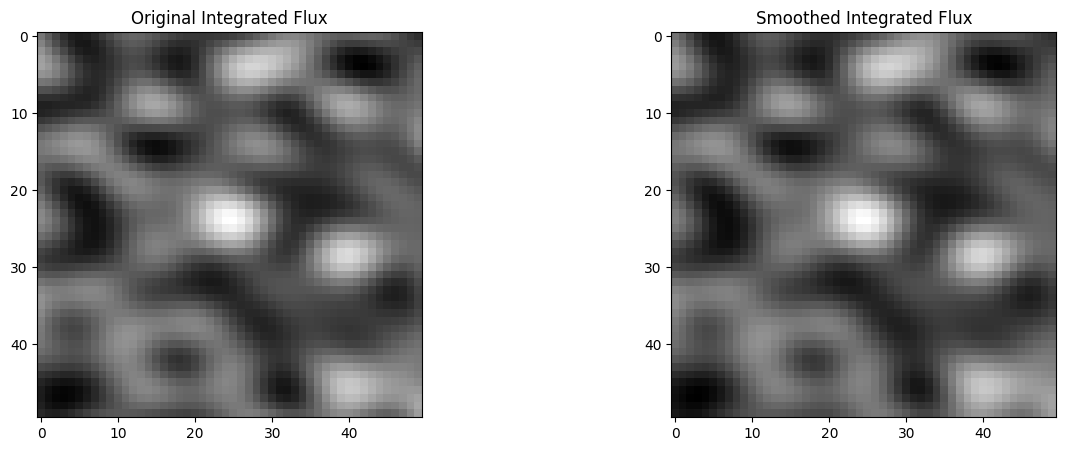

In [74]:
filename = r"C:\Users\lsann\Desktop\test\cropped_cubes\cropped_PJ231-20_a_08_7M_muid___A001_X15aa_X1f7.fits"
HDUL = fits.open(filename, memmap=True)
data = HDUL[0].data  

# Step 1: Apply Gaussian smoothing to enhance faint sources
smoothed_data = gaussian_filter(data, sigma=1)

# Integrated flux map
integrated_flux = np.sum(smoothed_data, axis=0)

# Step 2: Exclude a larger margin around the edges to prevent detecting noise or artifacts
margin = 20  # Larger margin to exclude edges
integrated_flux[:margin, :] = 0
integrated_flux[-margin:, :] = 0
integrated_flux[:, :margin] = 0
integrated_flux[:, -margin:] = 0

# Find the source coordinates (x_center, y_center)
y_center, x_center = np.unravel_index(np.argmax(integrated_flux), integrated_flux.shape)
print(f"Source coordinates (after filtering): (x_center, y_center) = ({x_center}, {y_center})")

# Step 3: Identify the slice that contains the maximum flux at the source coordinates
source_spectrum = data[:, y_center, x_center]
max_slice_index = np.argmax(source_spectrum)
print(f"Slice with maximum flux at the source coordinates: {max_slice_index}")

# Extract the 2D data from this slice
slice_data = data[max_slice_index]

# Step 4: Estimate the source radius based on 90% of the maximum flux in the selected slice
# Create radial profile centered at (x_center, y_center)
y, x = np.indices(slice_data.shape)
r = np.sqrt((x - x_center)**2 + (y - y_center)**2)
r = r.astype(int)

# Calculate the radial profile
tbin = np.bincount(r.ravel(), slice_data.ravel())
nr = np.bincount(r.ravel())
radialprofile = tbin / nr

# Apply smoothing to the radial profile to reduce noise
radialprofile_smooth = gaussian_filter(radialprofile, sigma=2)

# Define the 90% of maximum flux threshold
flux_threshold = 0.9 * np.max(radialprofile_smooth)

# Find the radius where the radial profile drops to 90% of the maximum flux
source_radius = np.argmax(radialprofile_smooth <= flux_threshold)
if source_radius == 0:  # Prevent zero radius issue
    source_radius = np.argmax(radialprofile_smooth > 0)
print(f"Source radius corresponding to 90% of maximum flux: {source_radius}")

# Estimate sigma as half of the radius (this is an approximation)
sigma_fit = source_radius / 2.0
print(f"Estimated sigma: {sigma_fit}")

# Step 5: Create masks for the source region and the background annulus
# Source mask: 3 sigma around the source center
source_mask = (x - x_center)**2 + (y - y_center)**2 <= (3 * sigma_fit)**2

# Background annulus mask: between 3 sigma and 6 sigma
inner_annulus = (x - x_center)**2 + (y - y_center)**2 > (3 * sigma_fit)**2
outer_annulus = (x - x_center)**2 + (y - y_center)**2 <= (6 * sigma_fit)**2
background_mask = inner_annulus & outer_annulus

# Step 6: Compute mean, standard deviation, and SNR for all slices using the defined masks
mean_fluxes = []
std_backgrounds = []
snr_values = []

for i in range(data.shape[0]):
    slice_data = data[i]
    
    # Mean of the source region in the current slice
    mean_source = np.mean(slice_data[source_mask])
    mean_fluxes.append(mean_source)

    # Standard deviation of the background region in the current slice
    std_background = np.std(slice_data[background_mask])
    std_backgrounds.append(std_background)

    # SNR for the current slice
    snr = mean_source / std_background if std_background != 0 else 0
    snr_values.append(snr)

# Step 7: Calculate the overall SNR of the cube
overall_snr = np.mean(snr_values)
print(f"Overall SNR of the cube: {overall_snr}")

# Step 8: Plot SNR across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), snr_values, label='SNR')
plt.xlabel('Slice Index')
plt.ylabel('SNR')
plt.title('SNR Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 9: Plot Mean Flux across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), mean_fluxes, label='Mean Flux', color='green')
plt.xlabel('Slice Index')
plt.ylabel('Mean Flux')
plt.title('Mean Flux Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 10: Plot Standard Deviation across all slices
plt.figure(figsize=(10, 6))
plt.plot(range(data.shape[0]), std_backgrounds, label='Standard Deviation', color='red')
plt.xlabel('Slice Index')
plt.ylabel('Standard Deviation')
plt.title('Standard Deviation Across All Slices')
plt.grid(True)
plt.legend()
plt.show()

# Step 11: Pixel flux distribution of the selected slice
plt.figure(figsize=(10, 6))
plt.hist(slice_data.ravel(), bins=100, color='blue', alpha=0.7)
plt.xlabel('Pixel Flux')
plt.ylabel('Number of Pixels')
plt.title('Pixel Flux Distribution of the Selected Slice')
plt.grid(True)
plt.show()

# Close the FITS file
HDUL.close()

# Visualize the regions if needed
plt.figure(figsize=(6, 6))
plt.imshow(source_mask + 2 * background_mask, origin='lower', cmap='viridis')
plt.title('Source (red) and Background (green) Regions')
plt.colorbar(label='Region Mask')
plt.show()

# Optional: Visualize the original and smoothed data for comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(np.sum(data, axis=0), cmap='gray')
plt.title('Original Integrated Flux')

plt.subplot(1, 2, 2)
plt.imshow(np.sum(smoothed_data, axis=0), cmap='gray')
plt.title('Smoothed Integrated Flux')

plt.show()